# Basic CNN based digit recognizer 

In this tutorial we shall go through a bangla digit recognizer model in details. Our model is going to be based on a convolutional neural network (CNN). The focus is to get familiar with the components of a bangla digit recognizer framework. There are three steps in building this digit recognizer, <br>
**Step 1 : Process the data.<br>
Step 2 : Design the model.<br>
Step 3 : Train the model.**

In [20]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D
from keras.models import Model, 
from keras.callbacks import ModelCheckpoint,
from keras import backend as K

While writing the codes, files and folder was organized in the following way     
* Numta
   * code
   * data
   * model
   * Final_DB 
      
The `code` folder contains this jupyter notebook, the processed images will be placed in the `data` folder, the trained model will be saved in the `model` folder, and the `Final_DB` folder has the raw image datasets.

## Step 1: Process the data

Our dataset comes from three different source, **A**, **B**, and **E**. For this tutorial we are using only dataset **A**.

In [21]:
#Declaring constants
FIG_WIDTH=16 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows of digits
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [22]:
project_dir='..' 
# We hall get all the filepaths that have .png extensions by using glob.glob() function 
paths_train_a=glob.glob(os.path.join(project_dir,'Final_DB','training-a','*.png'))
paths_test_a=glob.glob(os.path.join(project_dir,'Final_DB','testing-a','*.png'))
path_label_train_a=os.path.join(project_dir,'Final_DB','training-a.csv')
path_label_test_a=os.path.join(project_dir,'Final_DB','testing-a.csv')

### Define some utility functions

We shall write some helper functions to process and visualize the images.

In [174]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label):
    '''reads images from the filepaths, resizes them, and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: image label filepath
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
        img=cv2.resize(img,(RESIZE_DIM,RESIZE_DIM),interpolation=cv2.INTER_AREA) # resize image to 28x28
        X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    df = pd.read_csv(path_label) # read labels
    df=df.set_index('filename') 
    y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
    y=to_categorical(y_label,10) # transfrom integer value to categorical variable
    return X, y

def imshow_group(X,y,y_pred=None,n_per_row=10,phase='processed'):
    '''helper function to visualize a group of images along with their categorical true labels (y).
    Args:
        X: group of images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
        phase: If the images are plotted after resizing, pass 'processed' to phase argument. It will plot the image and its true label. If the image is plotted after prediction phase, pass predicted class probabilities to y_pred and 'prediction' to the phase argument. It will plot the image, the true label, and it's top 3 predictions with highest probabilities.
    '''
    n_sample=len(X)
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        img_sq=np.squeeze(img,axis=2)
        plt.imshow(img_sq,cmap='gray')
        if phase=='processed':
            plt.title(np.argmax(y[i]))
        if phase=='prediction':
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=RESIZE_DIM+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(RESIZE_DIM/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
            plt.text(RESIZE_DIM/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
                     horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

Next we are going to use the `get_data()` function to process all the images from dataset **A**

In [164]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a)
X_test_a,y_test_a=get_data(paths_test_a,path_label_test_a)

processed 19702/19702
processed 3489/3489


Let's see some samples of the processed data.

In [165]:
X_sample=X_train_a[:40]
y_sample=y_train_a[:40]

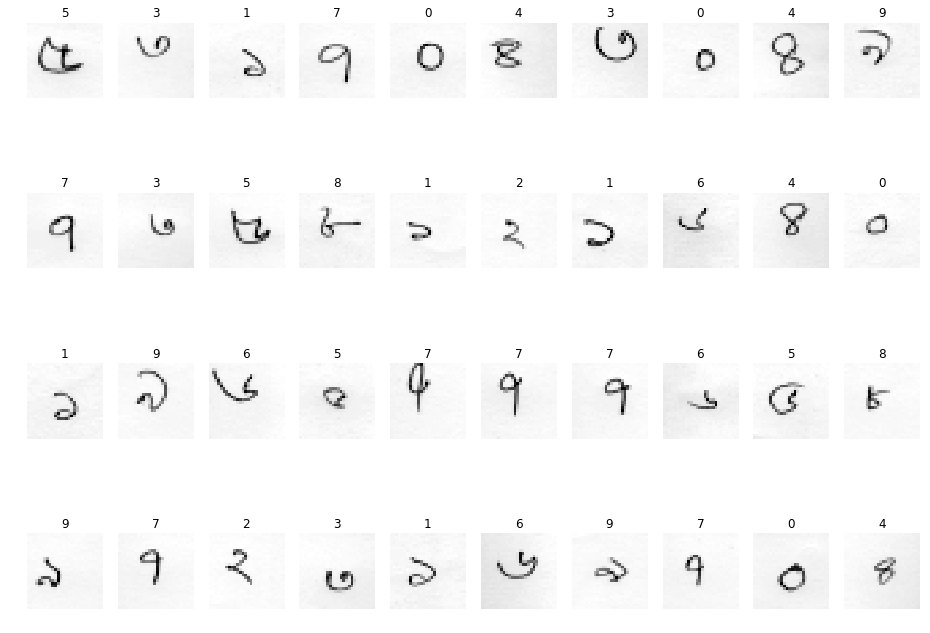

In [170]:
imshow_group(X=X_sample,y=y_sample,phase='processed')

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [101]:
indices=list(range(len(X_train_a)))
np.random.shuffle(indices)

ind=int(len(indices)*0.80)

X_train=X_train_a[indices[:ind]] # train data
y_train=y_train_a[indices[:ind]]

X_val=X_train_a[indices[-(len(indices)-ind):]] # validation data
y_val=y_train_a[indices[-(len(indices)-ind):]]

## Step 2: Design the model

In this step we shall design our neural network model. We are going to build a small model based on the classic LeNet architecture. We shall use only three convolutional layers. Each convolution layer has rectified linear unit (ReLU) activation which is followed by a max pooling layer. The convolution layers are followed by two dense layers. 

In [136]:
def get_model():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,1))
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    x=Flatten()(x)
    x=Dense(units=64)(x)
    x=Dense(units=10)(x)    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 32)          0         
__________

## Step 3: Train the model

In [137]:
path_model=os.path.join(project_dir,'model','model_tutorial.h5') # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=get_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=512, 
            epochs=100, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 15761 samples, validate on 3941 samples
Epoch 1/100
15761/15761 [==============================] - 11s - loss: 4.2040 - acc: 0.1114 - val_loss: 2.2127 - val_acc: 0.1791
Epoch 2/100
15761/15761 [==============================] - 10s - loss: 2.0910 - acc: 0.2476 - val_loss: 1.9593 - val_acc: 0.3212
Epoch 3/100
15761/15761 [==============================] - 10s - loss: 1.7911 - acc: 0.3905 - val_loss: 1.6597 - val_acc: 0.4446
Epoch 4/100
15761/15761 [==============================] - 10s - loss: 1.4998 - acc: 0.4950 - val_loss: 1.4217 - val_acc: 0.5364
Epoch 5/100
15761/15761 [==============================] - 9s - loss: 1.2849 - acc: 0.5787 - val_loss: 1.2516 - val_acc: 0.6044
Epoch 6/100
15761/15761 [==============================] - 9s - loss: 1.1110 - acc: 0.6410 - val_loss: 1.0896 - val_acc: 0.6498
Epoch 7/100
15761/15761 [==============================] - 10s - loss: 0.9900 - acc: 0.6748 - val_loss: 1.0007 - val_acc: 0.6810
Epoch 8/100
15761/15761 [=========================

15761/15761 [==============================] - 9s - loss: 0.2531 - acc: 0.9160 - val_loss: 0.4297 - val_acc: 0.8729
Epoch 65/100
15761/15761 [==============================] - 9s - loss: 0.2410 - acc: 0.9202 - val_loss: 0.4279 - val_acc: 0.8706
Epoch 66/100
15761/15761 [==============================] - 9s - loss: 0.2300 - acc: 0.9233 - val_loss: 0.4248 - val_acc: 0.8769
Epoch 67/100
15761/15761 [==============================] - 9s - loss: 0.2307 - acc: 0.9241 - val_loss: 0.4347 - val_acc: 0.8708
Epoch 68/100
15761/15761 [==============================] - 8s - loss: 0.2389 - acc: 0.9194 - val_loss: 0.4226 - val_acc: 0.8777
Epoch 69/100
15761/15761 [==============================] - 9s - loss: 0.2350 - acc: 0.9187 - val_loss: 0.4320 - val_acc: 0.8665
Epoch 70/100
15761/15761 [==============================] - 9s - loss: 0.2236 - acc: 0.9249 - val_loss: 0.4385 - val_acc: 0.8744
Epoch 71/100
15761/15761 [==============================] - 10s - loss: 0.2239 - acc: 0.9256 - val_loss: 0.419

After 100 epochs training accuracy is 94.61% and valiadation accuracy is 88.00%. 

Let's evaluate the model performance on the test set

In [139]:
model.evaluate(X_test_a,y_test_a)

3489/3489 [==============================] - 1s     


[0.49982582841161399, 0.86615075952995124]

The loss and accuracy is similar to the validation set.

## Result Analysis

Let's observe the images which is misclassified by our model.

In [140]:
predictions=model.predict(X_test_a) # get predictions for all the test data

In [141]:
# get the indice of the images which were incorrectly labeled
incorrect_ind=[]
for i,pred in enumerate(predictions):
    if np.argmax(y_test_a[i])!=np.argmax(pred):
        incorrect_ind.append(i)

In [147]:
# let's observe some samples of the incorrect data
X_inc=X_test_a[incorrect_ind[:40]]
y_inc=predictions[incorrect_ind[:40]]
y_true=y_test_a[incorrect_ind[:40]]

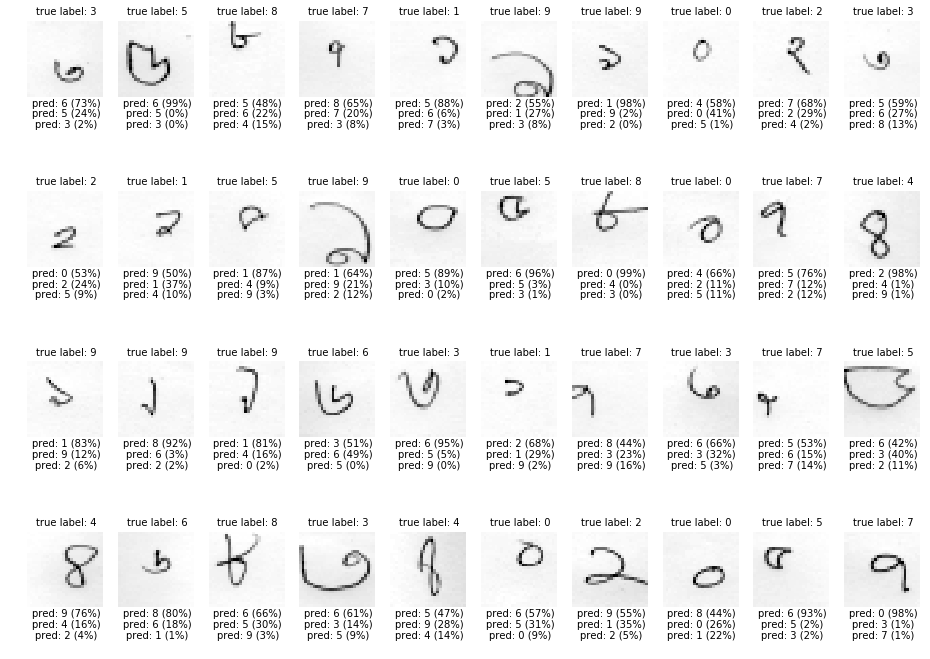

In [176]:
imshow_group(X=X_inc,y=y_true,y_pred=y_inc, phase='prediction')

Our model misclassifies often misclassifies '5' as '6', '9' as '1', among other mistakes. A few of the mistakes makes sense. For example, the '9' in the first image of the third row can easily be confused as '1'. But most of the mistakes are unacceptable. Since the neural network architecture used in this tutorial is shallow, has a simple architecture and not fine-tuned for this problem, its performance is not quite satisfactory. A deeper state of the art architecture should yield better results which will be investigated in future notebooks.